## Cargando los grafos de prueba

In [27]:
import igraph
import dgl
import torch
import heapq
import time
import progressbar
import pickle
import matplotlib.pyplot as plt
import os

In [14]:
PATH = "data/"
FEATURE_TYPE = "1"
input_dim = 32
directed_train = False

### Funciones

In [11]:
def get_rev_dgl(graph, feature_type='0', feature_dim=None, is_directed=False, use_cuda=False):
    """get dgl graph from igraph
    """
    
    src, dst = zip(*graph.get_edgelist())

    if use_cuda:
        dglgraph = dgl.graph((dst, src)).to(torch.device("cuda:0"))
    else:
        dglgraph = dgl.graph((dst, src))
        
    if not is_directed:
        dglgraph.add_edges(src, dst)

    if use_cuda:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim).cuda()
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float().cuda()

    else:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim)
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float()
        
    return dglgraph


def gen_zero_feature(graph, feature_dim):
    """Generate all-zero features
    """
    return torch.zeros(graph.vcount(), feature_dim)


def gen_one_feature(graph, feature_dim):
    """Generate all-one features
    """
    return torch.ones(graph.vcount(), feature_dim)


def gen_deg_feature(graph, *args):  # args is only a placeholder
    indegree = torch.tensor(graph.indegree()).float()
    zeros = torch.zeros(graph.vcount(), 1).squeeze(1)
    return torch.stack([indegree, zeros], dim=1)


def gen_one_hot_feayture(graph, *args):  # args is only a placeholder
    return torch.eye(graph.vcount()).float()


FEATURE_TYPE_DICT = {
    "0": gen_zero_feature,
    "1": gen_one_feature,
    "onehot": gen_one_hot_feayture,
    "deg": gen_deg_feature,
}

In [32]:
Graphs = [graph for graph in os.listdir(PATH) if ".txt" in graph]
#"""
MeanNodes = []

N = len(Graphs)

for file in progressbar.progressbar(Graphs):
    graph = igraph.Graph().Read_Edgelist(
        f"{PATH}{file}", directed=False)

    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda = False)
    
    MeanNodes.append(dglgraph.num_nodes())
#"""
print(f"MEAN NODES: {np.mean(MeanNodes):.2f}\nSTD:{np.std(MeanNodes):.2f}\nMAX: {np.max(MeanNodes):.2f}\nMIN: {np.min(MeanNodes):.2f}")

MEAN NODES: 44170.41
 STD:67189.83
MAX: 317080.00
MIN: 620.00


(array([7., 3., 4., 1., 2., 3., 1., 2., 1., 2.]),
 array([  620. ,  6931.1, 13242.2, 19553.3, 25864.4, 32175.5, 38486.6,
        44797.7, 51108.8, 57419.9, 63731. ]),
 <BarContainer object of 10 artists>)

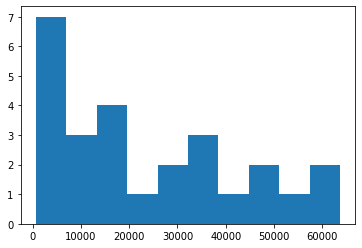

In [38]:
MeanNodes = np.array(MeanNodes)
plt.hist(MeanNodes[MeanNodes < 100_000], bins = 10)

## Convirtiendo dimacs a txt

In [40]:
Graphs

['as-caida20071105.txt',
 'ca-AstroPh.txt',
 'DBLP.txt',
 'dnc-corecipient.txt',
 'douban.txt',
 'Enron.txt',
 'facebook-wosn-links.txt',
 'Facebook.txt',
 'fb-pages-artist.txt',
 'fb-pages-company.txt',
 'fb-pages-food.txt',
 'fb-pages-government.txt',
 'fb-pages-media.txt',
 'fb-pages-politician.txt',
 'fb-pages-public-figure.txt',
 'fb-pages-sport.txt',
 'fb-pages-tvshow.txt',
 'git.txt',
 'HepPh.txt',
 'loc-brightkite_edges.txt',
 'loc-gowalla_edges.txt',
 'moreno_names_names.txt',
 'Nethept.txt',
 'petster-friendships-hamster-uniq.txt',
 'soc-gemsec-HR.txt',
 'soc-gemsec-HU.txt',
 'soc-gemsec-RO.txt',
 'soc-hamsterster.txt',
 'topology.txt']